## Intro

This notebook runs bagged sklearn trees on the winequality dataset in a regression scenario

In [1]:
# # # local
project_directory = "../"


# # # # colab
# from google.colab import drive
# drive.mount('/content/drive')
# project_directory = "/content/drive/MyDrive/colab_working_directory/diversity-enforced-ensembles/"
# !pip install cached-property

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np

# allow import of decompose locally
import sys
sys.path.append(project_directory + 'src/')

from sklearn.ensemble import BaggingRegressor
from decompose import SquaredLoss
import bvdlib
from sklearn.metrics import mean_squared_error

## Pre-Process Data

In [3]:
save_path = project_directory + "experiments/results/SKlearn_baggedTree_over_n_members_winequality_regression.pkl"

In [4]:
# get data
data_path = Path(project_directory + 'data/Wine_Quality/data.csv')

winequal_data = pd.read_csv(data_path)
winequal_data

x = winequal_data.iloc[:, 1:-2].to_numpy()
y = winequal_data.iloc[:, -2:-1].to_numpy().squeeze()

print("x shape", x.shape)
print("y shape", y.shape)

x shape (6497, 11)
y shape (6497,)


In [5]:
#define settings

n_trials = 100
data_percentage_training = int(0.8 * len(y))
num_training =  int(0.8 * data_percentage_training) # percent of data for each trial from training
trial_space = np.arange(1,21) # Test estimators from 1 to 20

In [6]:
# seed experiment
experiment_seed = 0
np.random.seed(experiment_seed)
# split and preprocess data,
rng = np.random.default_rng()
shuffled_indices = rng.permutation(len(y))

train_indices = shuffled_indices[:data_percentage_training]
test_indices = shuffled_indices[data_percentage_training:]
train_data = x[train_indices, :]
train_labels = y[train_indices]
test_data = x[test_indices, :]
test_labels = y[test_indices]

## Run Experiments

In [7]:
model_function = BaggingRegressor
decomp_fn = SquaredLoss
loss_fn = mean_squared_error

# define a trial
def trial_run(trial):

    trial_x, trial_y = trial.get_data

    # init model
    n_estim = trial.get_singular_parameter()
    model = model_function(n_estimators=n_estim)

    model.fit(trial_x, trial_y)


    trial_results_array = np.zeros((n_estim, len(test_data)))

    train_losses = []
    for i, member in enumerate(model.estimators_):
        train_preds = member.predict(trial_x)
        train_losses.append(loss_fn(trial_y, train_preds))
        member_preds = member.predict(test_data)
        trial_results_array[i, :] = member_preds

    return trial_results_array, np.mean(train_losses)

# save results


study = bvdlib.Study(trial_space, train_data, train_labels, test_data, test_labels,
                     num_training, n_trials, decomp_fn)

results = study.run_trials(trial_run)


results.save_results(save_path)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [07:03<00:00, 21.16s/it]


<Axes: xlabel='n_estimators'>

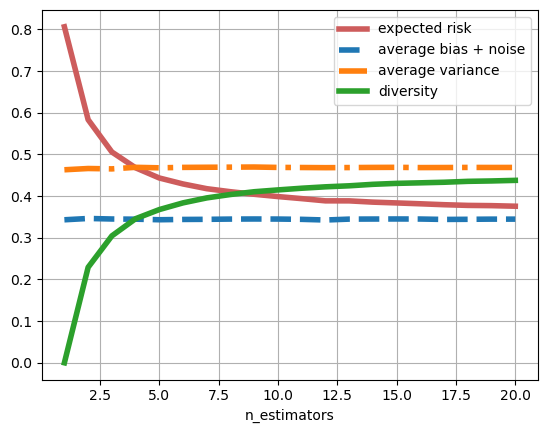

In [8]:
from decompose.plotting_utils import plot_bvd

plot_bvd(results)